# Computing flow past a cylinder in `ViscousFlow`

In [1]:
using ViscousFlow

In [2]:
using Plots
pyplot()
clibrary(:colorbrewer)
default(grid = false)

### Solve flow past a stationary body

Set the flow parameters

In [3]:
Re = 200; # Reynolds number
U = 1.0; # Free stream velocity
U∞ = (U,0.0);

Set up points on the body.

In [4]:
n = 100;
body = Bodies.Ellipse(0.5,n)

Elliptical body with 100 points and semi-axes (0.5,0.5)
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


Transform the body to lie at a specific position. Here, we just put it at the origin.

In [5]:
cent = (0.0,0.0)
α = 0.0
T = RigidTransform(cent,α)
T(body) # transform the body to the current configuration

Elliptical body with 100 points and semi-axes (0.5,0.5)
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


Set up the domain and plot the body inside it.

In [6]:
xlim = (-1.0,3.0)
ylim = (-1.0,1.0);

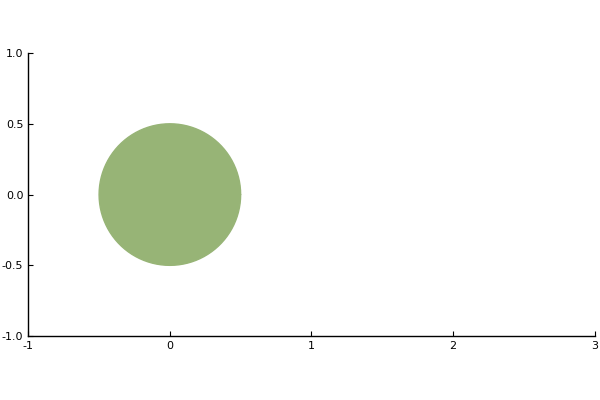

In [7]:
plot(body,xlim=xlim,ylim=ylim)

Now set up the coordinate data for operator construction

In [8]:
X = VectorData(body.x,body.y);
#X̃ = VectorData(body.x̃,body.ỹ);

Set the grid cell size and time step size.

In [9]:
Δx = 0.02
cfl = 0.5
Δt = min(cfl*Δx,0.5*Δx^2*Re)

0.01

### Now set up the system

Set up the state vector and constraint force vector for a static body

In [10]:
sys = Systems.NavierStokes(Re,Δx,xlim,ylim,Δt,U∞ = U∞, X̃ = X, isstore = true)

Navier-Stokes system on a grid of size 202 x 102

In [11]:
w₀ = Nodes(Dual,size(sys));
f = VectorData(X);

In [12]:
wf = Systems.PointForce(w₀,(1.5,0.0),10.0,4.0,1.0,sys)

Transient point force applied on the Nodes{Dual,202,102} field.
   strength = 10.0
   location = (1.5, 0.0)
   central time = 4.0
   half-interval = 1.0


In [13]:
xg, yg = coordinates(w₀,dx=Δx,I0=Systems.origin(sys))

(-1.01:0.02:3.0100000000000002, -1.01:0.02:1.01)

Set up the integrator here

In [14]:
plan_intfact(t,u) = Systems.plan_intfact(t,u,sys)
plan_constraints(u,t) = TimeMarching.plan_constraints(u,t,sys)
r₁(u,t) = TimeMarching.r₁(u,t,sys) + wf(t)
r₂(u,t) = TimeMarching.r₂(u,t,sys)

@time ifherk = IFHERK(w₀,f,sys.Δt,plan_intfact,plan_constraints,(r₁,r₂),rk=TimeMarching.RK31,isstored=true)

  6.683975 seconds (12.66 M allocations: 1.085 GiB, 6.29% gc time)


Order-3 IF-HERK integrator with
   State of type Nodes{Dual,202,102}
   Force of type VectorData{100}
   Time step size 0.01


Initialize the state vector and the history vectors

In [15]:
t = 0.0
u = deepcopy(w₀)

fx = Float64[];
fy = Float64[];
thist = Float64[];

uhist = [];
tsample = 0.2; # rate at which to store field data

### Advance the system!

Set the time range to integrate over.

In [16]:
tf = 30.0;
T = Δt:Δt:tf;

In [17]:
@time for ti in T
    global t, u, f = ifherk(t,u)
    
    push!(thist,t)
    push!(fx,sum(f.u)*Δx^2)
    push!(fy,sum(f.v)*Δx^2)
    (isapprox(mod(t,tsample),0,atol=1e-8) || isapprox(mod(t,tsample),tsample,atol=1e-8)) ? push!(uhist,u) : nothing
end
println("solution completed through time t = ",t)

254.074707 seconds (1.12 G allocations: 54.627 GiB, 4.88% gc time)
solution completed through time t = 30.00000000000189


In [18]:
thist[end]

30.00000000000189

#### Plotting

Basic plot

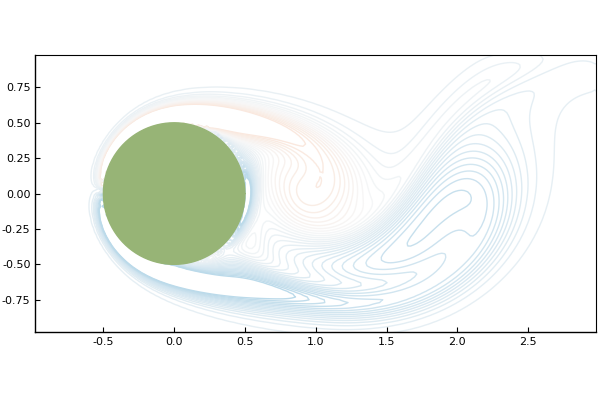

In [19]:
plot(xg,yg,uhist[end],levels=range(-0.1,stop=0.1,length=30), color = :RdBu,xlim=(-1+Δx,3-Δx),ylim=(-1+Δx,1-Δx),width=1)
plot!(body)

Make a movie

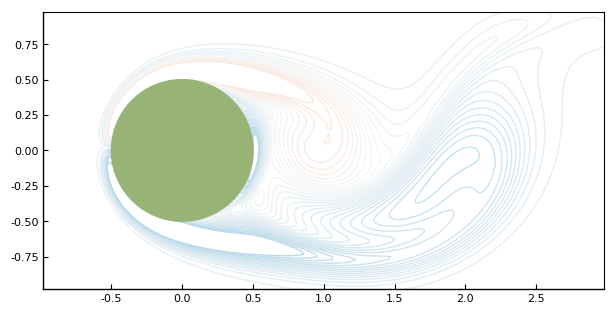

┌ Info: Saved animation to 
│   fn = /Users/jeff/ViscousFlow/examples/cylinderRe200.gif
└ @ Plots /Users/jeff/.julia/packages/Plots/qh1wV/src/animation.jl:90


Plots.AnimatedGif("/Users/jeff/ViscousFlow/examples/cylinderRe200.gif")

In [20]:
anim = @animate for i = 1:length(uhist)
    plot(xg,yg,uhist[i],levels=range(-0.1,stop=0.1,length=30),color = :RdBu,xlim=(-1+Δx,3-Δx),ylim=(-1+Δx,1-Δx))
    plot!(body)
end
gif(anim,"cylinderRe200.gif")

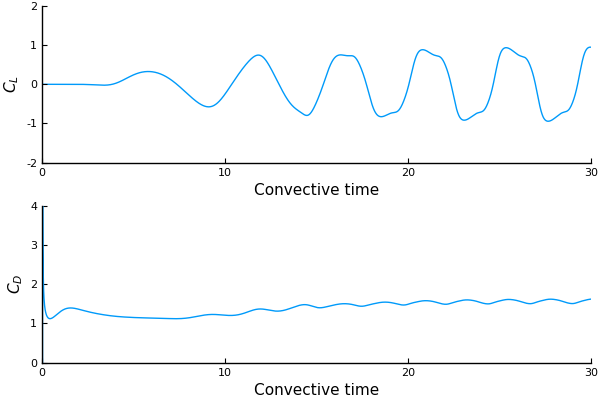

In [21]:
plt = plot(layout = (2,1), size = (600, 400))
plot!(plt[1],thist,2*fy,xlim=(0,30),ylim=(-2,2),xlabel="Convective time",ylabel="\$C_L\$",legend=false)
plot!(plt[2],thist,2*fx,xlim=(0,30),ylim=(0,4),xlabel="Convective time",ylabel="\$C_D\$",legend=false)
plt

In [22]:
using Statistics

In [23]:
thist[3000]

30.00000000000189

In [30]:
Statistics.mean(2*fx)

1.307759701804912

In [32]:
using Pkg

In [33]:
Pkg.add("FFTW")

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
 Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
  [7a1cc6ca] + FFTW v0.2.4
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]


In [34]:
using FFTW

In [35]:
fft(fx)

3000-element Array{Complex{Float64},1}:
  1961.6395527073682 + 0.0im               
  -130.9955220894658 + 154.9277919290999im 
  -92.35257168263149 + 30.194809081364568im
 -124.98358692223584 + 4.878021444668im    
 -130.52957799712146 + 7.502131878946741im 
 -136.84704259473472 + 6.267905305803859im 
 -135.19963408568682 + 8.872988300622477im 
  -135.9271764065013 + 7.7679493768210754im
 -136.51605357994052 + 7.779823718421892im 
 -138.73147306418542 + 11.674193041482201im
 -128.62169828772096 + 13.861622725189225im
 -132.64901382568348 + 1.77211738089636im  
   -135.732155895115 + 8.242809926055713im 
                     ⋮                     
   -135.732155895115 - 8.242809926055713im 
 -132.64901382568348 - 1.7721173808963535im
   -128.621698287721 - 13.861622725189221im
  -138.7314730641854 - 11.674193041482201im
  -136.5160535799405 - 7.779823718421893im 
 -135.92717640650127 - 7.767949376821077im 
  -135.1996340856868 - 8.872988300622477im 
 -136.84704259473475 - 6.26790530580

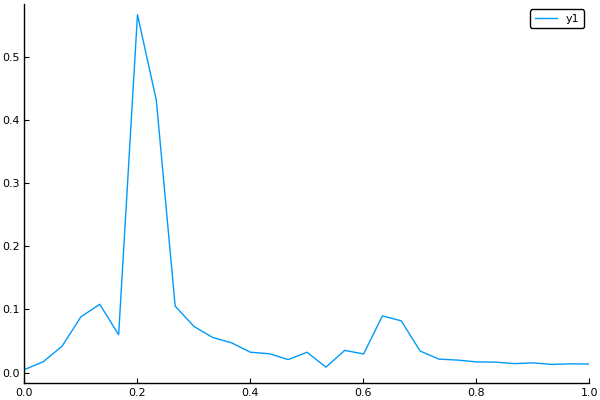

In [36]:
nt = length(thist)
nfreq = (nt-1)÷2+1
fsamp = 1/Δt
freq = 0.5*fsamp*range(0,stop=1.0,length=nfreq)
fhat = fft(fy[1:nt-1])/(nt-1)
plot(freq,4*abs.(fhat[1:nfreq]),xlim=(0,1))

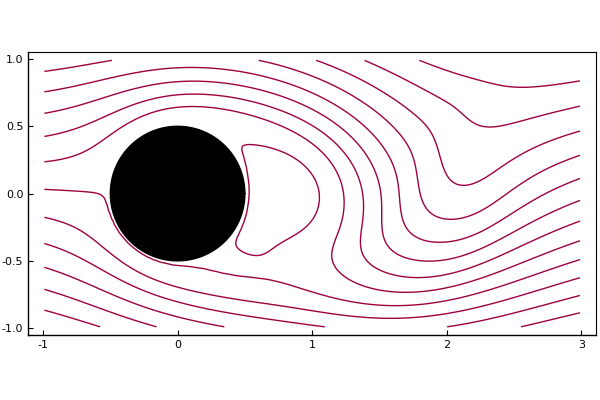

In [39]:
xg,yg = coordinates(u,dx=Δx,I0=Systems.origin(sys))
ψ = deepcopy(uhist[end])
ψ .= -(sys.L\uhist[end])*Δx .+ repeat(collect(yg)',size(sys,1))
plot(xg,yg,ψ,trim=1,clim=(-0.1,0.1))
plot!(body,fillcolor=:black,linecolor=:black)